In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

import scanpy as sc 
import numpy as np

# from utils import adata_train
adata_train = sc.read_h5ad('./.cache/adata_train.h5ad')

In [3]:
adata_train.shape

(10277, 2833)

In [ ]:
from tqdm import tqdm
import pandas as pd

import celloracle as co

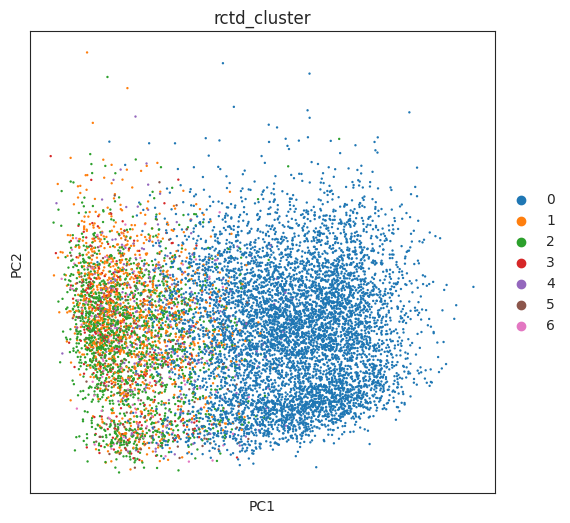

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [6, 6]

sc.tl.pca(adata_train, svd_solver='arpack')
sc.pl.pca(adata_train, color='rctd_cluster', layer='imputed_count')

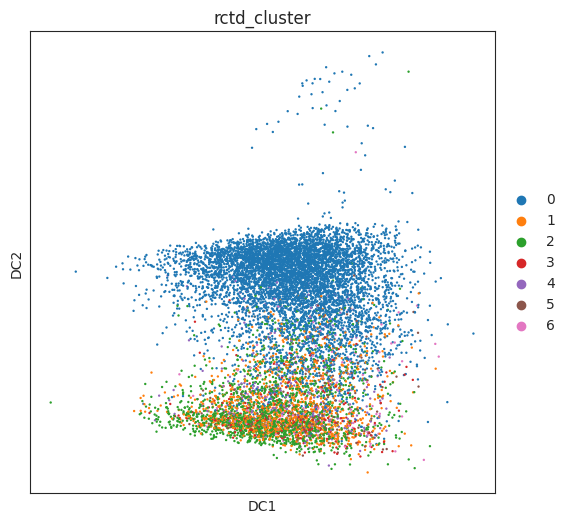

In [37]:
sc.pp.neighbors(adata_train, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata_train)
sc.pl.diffmap(adata_train, color='rctd_cluster', layer='imputed_count')

2024-09-07 13:13:38.783334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 13:13:38.886508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 13:13:38.917433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 13:13:39.085256: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 13:13:41.167845: W tensorflow/compiler/tf2

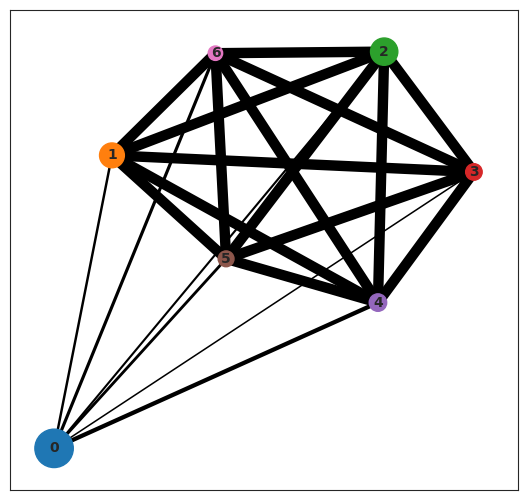

In [6]:
sc.pp.neighbors(adata_train, n_neighbors=15, use_rep='X_diffmap')
sc.tl.paga(adata_train, groups='rctd_cluster')
sc.pl.paga(adata_train)

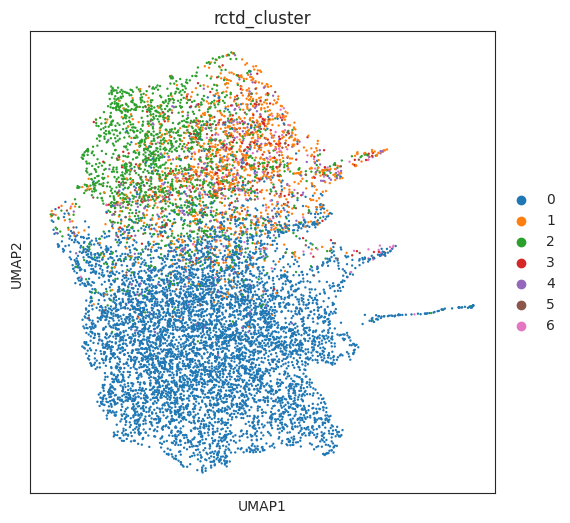

In [7]:
sc.tl.umap(adata_train)
sc.pl.umap(adata_train, color='rctd_cluster', layer='imputed_count')

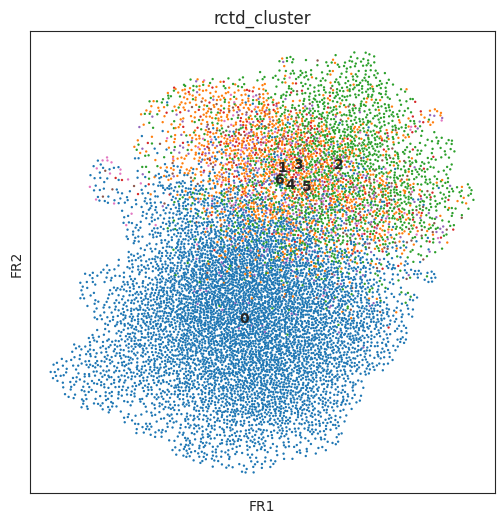

In [8]:
sc.tl.draw_graph(adata_train, init_pos='paga', random_state=123)
sc.pl.draw_graph(adata_train, color='rctd_cluster', legend_loc='on data')

<AxesSubplot: title={'center': 'cluster'}, xlabel='spatial1', ylabel='spatial2'>

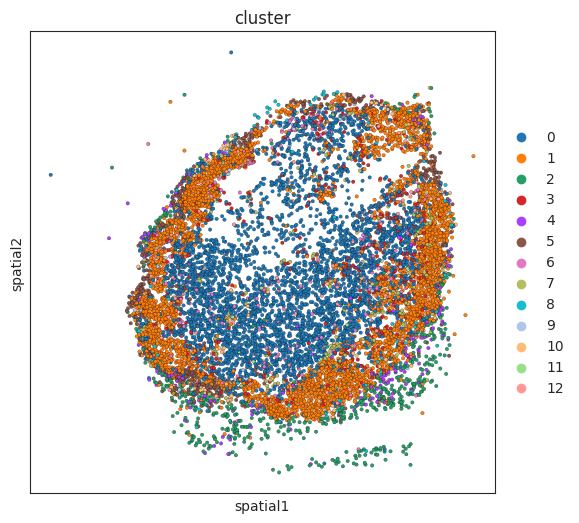

In [9]:
sc.pl.embedding(adata_train, color='cluster', basis="spatial", s=25, show=False, edgecolor='black', linewidth=0.15)

In [10]:
import spaceoracle

so = spaceoracle.SpaceOracle(
    adata=adata_train,
    annot='rctd_cluster', 
    max_epochs=1, 
    learning_rate=7e-4, 
    spatial_dim=64,
    batch_size=256,
    init_betas='zeros',
    rotate_maps=True,
    cluster_grn=True,
    regularize=True,
)


In [11]:
import pickle 

with open('beta_dict.pickle', 'rb') as handle:
    so.beta_dict = pickle.load(handle)
so.coef_matrix = pd.read_csv('coef_matrix.csv', index_col=0)

In [12]:
so.adata

AnnData object with n_obs × n_vars = 10277 × 2833
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'rctd_celltypes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'hvg', 'log1p', 'rctd_cluster_colors', 'pca', 'neighbors', 'diffmap_evals', 'paga', 'rctd_cluster_sizes', 'umap', 'draw_graph'
    obsm: 'X_spatial', 'rctd_results', 'spatial', 'spatial_maps', 'X_pca', 'X_diffmap', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'distances', 'connectivities'

In [38]:
so.cluster_column_name = 'rctd_cluster'

# so.embedding_name = 'X_draw_graph_fr'
# so.embedding = so.adata.obsm['X_draw_graph_fr']

# so.embedding_name = 'X_spatial'
# so.embedding = so.adata.obsm['X_spatial']

so.embedding_name = 'X_umap'
so.embedding = so.adata.obsm['X_umap']

In [39]:
from spaceoracle.applications import Pseudotime_calculator

# pt = Pseudotime_calculator(oracle_object=so)

pt = Pseudotime_calculator(adata=so.adata,
                           obsm_key=so.embedding_name, # Dimensional reduction data name
                           cluster_column_name=so.cluster_column_name # Clustering data name
                           )

53


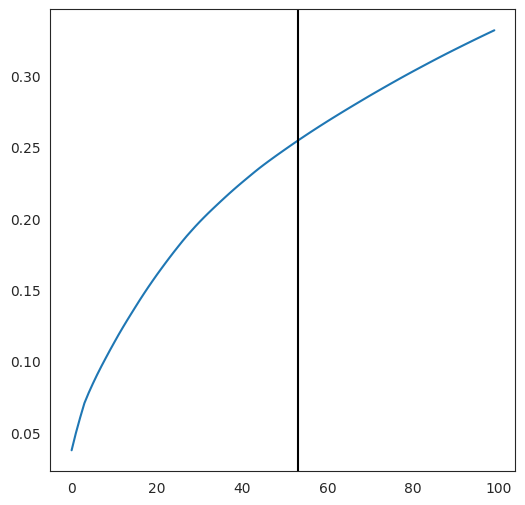

In [40]:
# Select important PCs
plt.plot(np.cumsum(so.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(so.pca.explained_variance_ratio_))>0.002))[0][0]
print(n_comps)

plt.axvline(n_comps, c="k")
plt.show()
n_comps = min(n_comps, 50)

In [41]:
n_cell = so.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :10277
Auto-selected k is :256


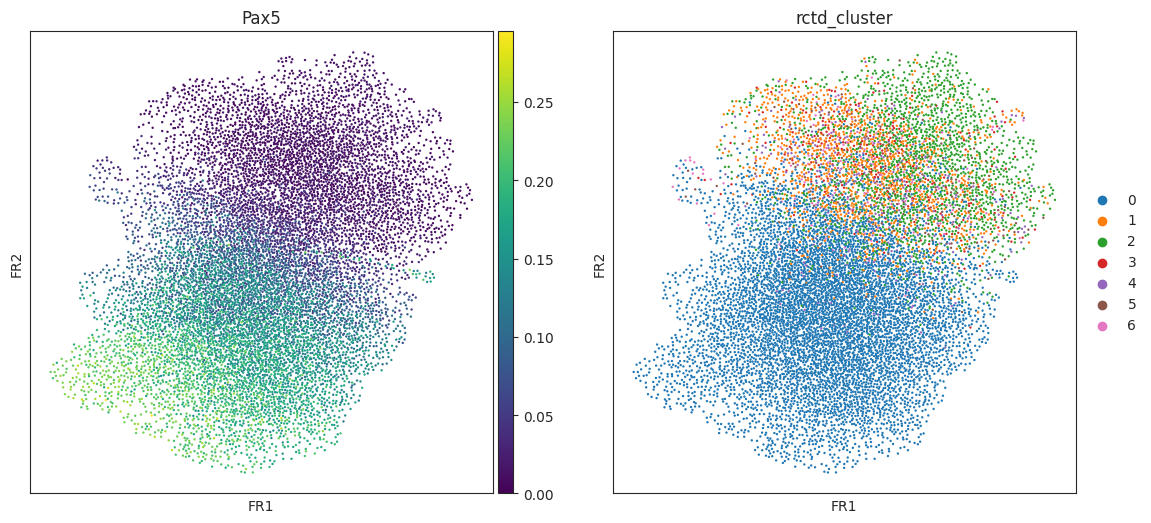

In [42]:
goi = 'Pax5'
sc.pl.draw_graph(so.adata, color=[goi, so.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

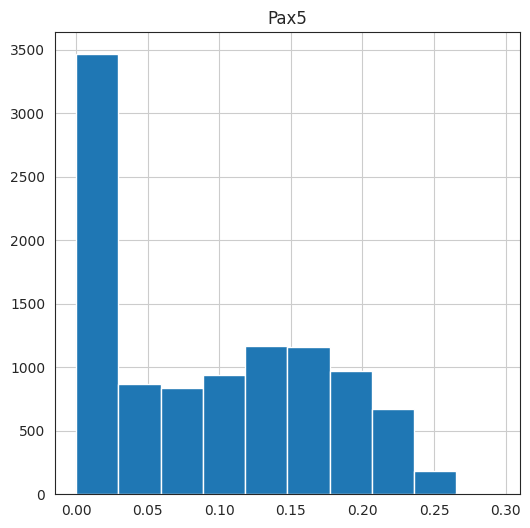

In [43]:
# Plot gene expression in histogram
sc.get.obs_df(so.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [44]:
so.knn_imputation(so.adata, so.pcs, n_pca_dims=n_comps, k=k, balanced=False, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)
                      

In [45]:
# coef_matrix = so.get_coef_matrix(so.adata.copy())
# perturbed_matrix = so.perturb(so.adata.to_df().values, coef_matrix, n_propagation=3)

# so.adata.layers['delta_X'] = so.adata.layers['imputed_count'] - perturbed_matrix
# so.adata.layers['delta_X'].shape

so.simulate_shift(perturb_condition={goi: 0.0})

Running simulation 3/3: 100%|██████████| 10277/10277 [04:21<00:00, 39.30it/s]


In [46]:
so.estimate_transition_prob()

In [47]:
so.calculate_embedding_shift(sigma_corr=0.05)

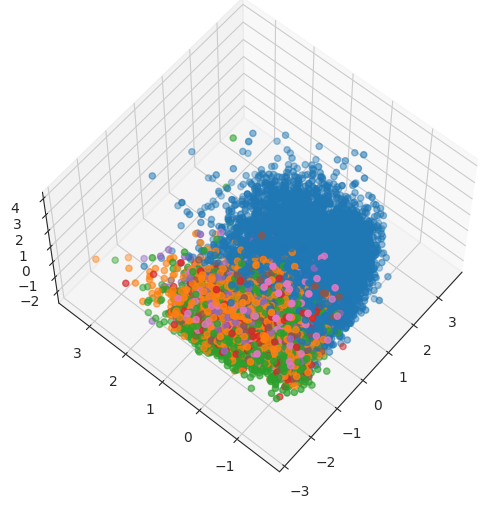

In [48]:
so.plot_pca()

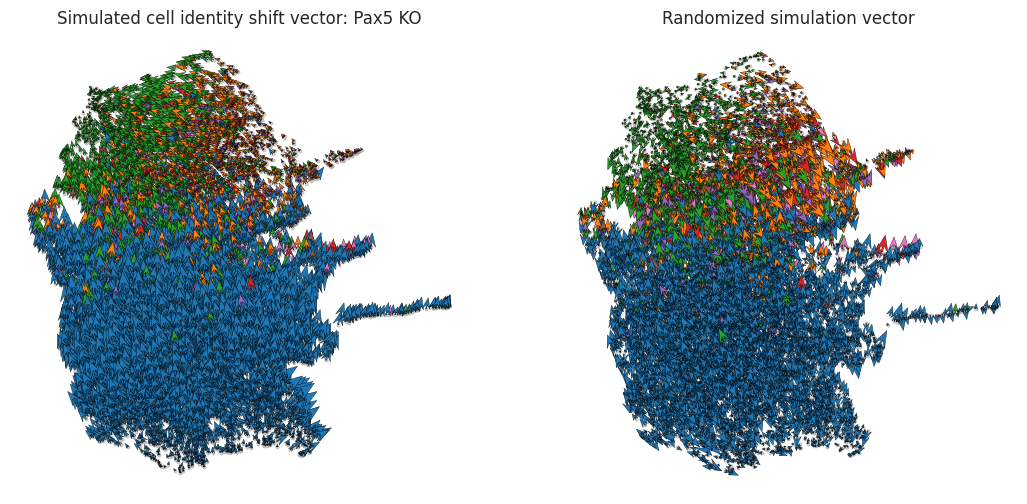

In [49]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
so.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [50]:
# n_grid = 40 is a good starting value.
n_grid = 40
so.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

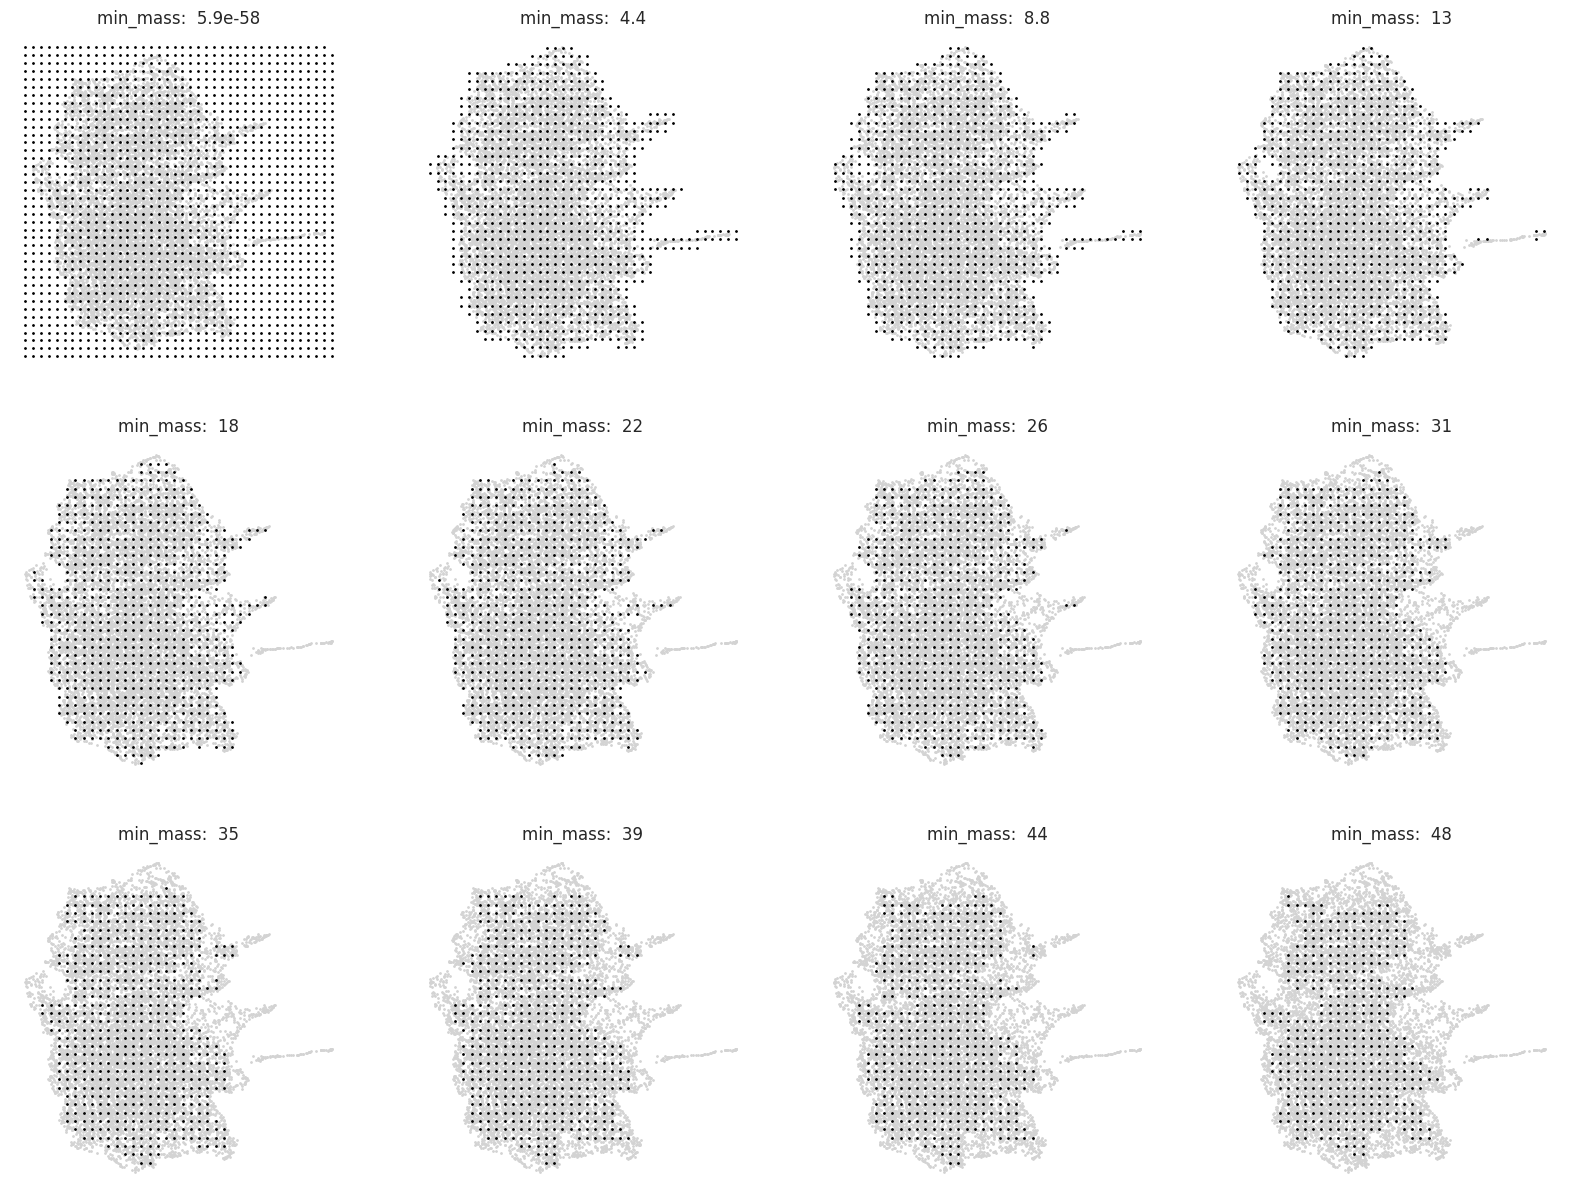

In [51]:
# Search for best min_mass.
so.suggest_mass_thresholds(n_suggestion=12)

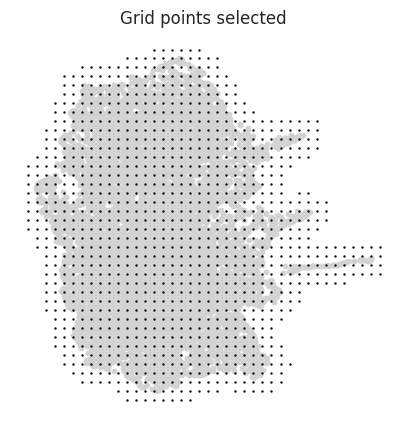

In [52]:
min_mass = 0.077
so.calculate_mass_filter(min_mass=min_mass, plot=True)

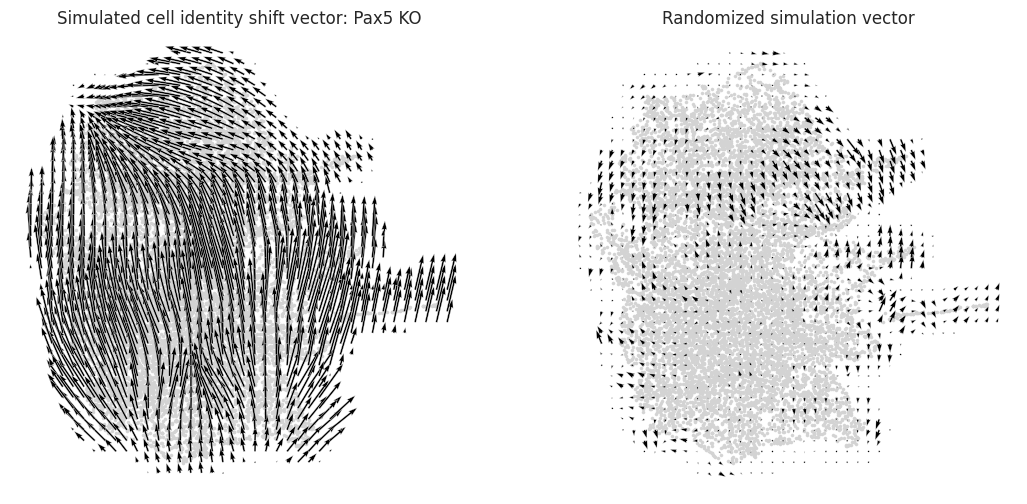

In [53]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 7
# Show quiver plot
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

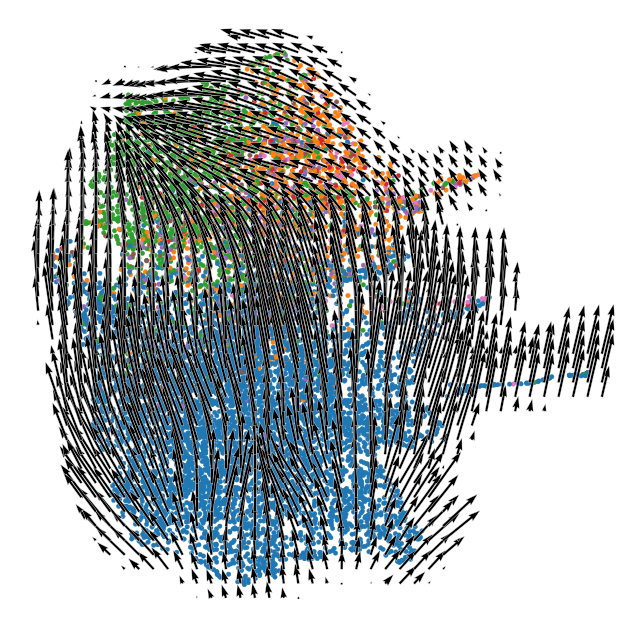

In [54]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

so.plot_cluster_whole(ax=ax, s=10)
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)